# Twitter Account Analytics
- **Created by Andrés Segura Tinoco**
- **Created on May 24, 2020**

In [1]:
# Import util libraries
import tweepy
import random
import numpy as np
import pandas as pd
import yaml
import warnings
import calendar
import time
from datetime import date
from PIL import Image
from collections import Counter

In [2]:
# Import NLP libraries
import re
import spacy.lang.es as es
import spacy.lang.en as en
from textblob import TextBlob
from wordcloud import WordCloud

In [3]:
# Import plot libraries
import matplotlib.pyplot as plt

In [4]:
warnings.filterwarnings('ignore')

#### Define Util Functions

In [5]:
# Util function - Read dict from yaml file
def get_dict_from_yaml(yaml_path):
    result = dict()
    
    with open(yaml_path) as f:
        yaml_file = f.read()
        result = yaml.load(yaml_file, Loader=yaml.FullLoader)
    
    return result

In [6]:
# Util function - Plot column chart
def plot_col_chart(df, x_var, y_var, title, legend, figsize, color='green', x_label=None):
    fig, ax = plt.subplots()
    df.plot.bar(ax=ax, x=x_var, y=y_var, color=color, alpha=0.75, figsize=figsize)
    ax.legend(legend)
    if x_label:
        x = np.arange(len(x_label))
        plt.xticks(x, x_label, rotation=45)
    else:
        plt.xticks(rotation=45)
    plt.title(title, fontsize=16)
    plt.xlabel(x_var.capitalize())
    plt.ylabel(y_var.capitalize())
    plt.show()

In [7]:
# Util function - Plot column chart
def plot_bar_chart(df, x_var, y_var, title, legend, figsize, color='blue'):
    fig, ax = plt.subplots()
    df.plot.barh(ax=ax, x=x_var, y=y_var, alpha=0.75, figsize=(8, 10))
    ax.legend(legend)
    plt.title(title, fontsize=16)
    plt.xlabel(y_var.capitalize())
    plt.ylabel(x_var.capitalize())
    plt.show()

## 1. Create connection to the Tweepy API

In [8]:
# Read twitter bot credentials
yaml_path = 'config\credentials.yml'
twt_login = get_dict_from_yaml(yaml_path)

# Setup bot credentials
consumer_key = twt_login['consumer_key']
consumer_secret = twt_login['consumer_secret']
access_token = twt_login['access_token']
access_token_secret = twt_login['access_token_secret']

In [9]:
# Authenticate to Twitter
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# Create API object
api = tweepy.API(auth)

try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

Authentication OK


## 2. Read the list of tweets from an account

In [10]:
# Util function - Fetch tweets list from a specific user
# Note: Twitter only allows access to a users most recent 3240 tweets with this method
def get_all_tweets(api, screen_name):
    all_tweets = []
    
    # Make initial request for most recent tweets (200 is the maximum allowed count)
    try:
        new_tweets = api.user_timeline(screen_name = screen_name, count=200, tweet_mode='extended')

        # Save most recent tweets
        all_tweets.extend(new_tweets)

        # Save the id of the oldest tweet less one
        oldest = all_tweets[-1].id - 1

        # Keep grabbing tweets until there are no tweets left to grab
        while len(new_tweets) > 0:

            # All subsiquent requests use the max_id param to prevent duplicates
            new_tweets = api.user_timeline(screen_name = screen_name, count=200, tweet_mode='extended', max_id=oldest)

            # Save most recent tweets
            all_tweets.extend(new_tweets)

            # Update the id of the oldest tweet less one
            oldest = all_tweets[-1].id - 1
    
    except (socket.timeout, exceptions.ReadTimeoutError, exceptions.ProtocolError, tweepy.TweepError) as e:
        print('Error:', e)
    
    # Transform the tweepy tweets into an array that contains the relevant fields of each tweet
    tweet_list = []
    for tweet in all_tweets:
        new_tweet = {
            'id': tweet.id_str,
            'created_at': tweet.created_at,
            'message': tweet.full_text,
            'lang': tweet.lang,
            'hashtags': [ht['text'] for ht in tweet.entities['hashtags']],
            'retweet_count': tweet.retweet_count,
            'favorite_count': tweet.favorite_count,
            'retweeted': tweet.retweeted,
            'source': tweet.source
        }
        tweet_list.append(new_tweet)
    
    return tweet_list

In [11]:
# Show user account details
tw_user_name = "@seguraandres7"
user = api.get_user(screen_name=tw_user_name)

print("User details:")
print(user.name)
print(user.description)
print(user.location)
print(user.created_at)

User details:
Andres Segura Tinoco
I was born in Colombia and I grew up in Venezuela. I'm a computer and information engineer, interested in: DataViz, ML, Big Data, NLP, HPC & Cloud Computing.
Bogotá, DC, Colombia
2010-09-06 04:35:36


In [12]:
# Fetching tweet list from a specific user
tweet_list = get_all_tweets(api, screen_name=tw_user_name)

In [13]:
# Show the last tweet
tweet_list[0]

{'id': '1266772220136886274',
 'created_at': datetime.datetime(2020, 5, 30, 16, 43, 27),
 'message': 'Mi stack de libros de #ComputerScience adquiridos en 3 países distintos. La mayoría me acompañó durante mi tiempo en la universidad.\n\ncc: @AlfaomegaMex @mhelatam #PearsonPrenticeHall #AddisonWesley https://t.co/nG1nqU72eO',
 'lang': 'es',
 'hashtags': ['ComputerScience', 'PearsonPrenticeHall', 'AddisonWesley'],
 'retweet_count': 0,
 'favorite_count': 1,
 'retweeted': False,
 'source': 'Twitter for iPhone'}

## 3. Followers Basic Analytics

### 3.1. List of Followers

In [14]:
# Get a list of all followers of a twitter account
followers = []
for page in tweepy.Cursor(api.followers, screen_name=tw_user_name, wait_on_rate_limit=True, count=200).pages():
    try:
        followers.extend(page)
    except tweepy.TweepError as e:
        time.sleep(10)

print('Number of followers: %s' % len(followers))

Number of followers: 113


### 3.2. Followers Account Creation

In [15]:
# Get year the account was created
flw_creation = Counter()
for flw in followers:
    created_at = flw.created_at.date()
    year = created_at.year
    flw_creation[year] += 1

In [16]:
# Cooking dataframe
df = pd.DataFrame.from_records(flw_creation.most_common(), columns = ['year', 'frequency']).sort_values(by=['year'])

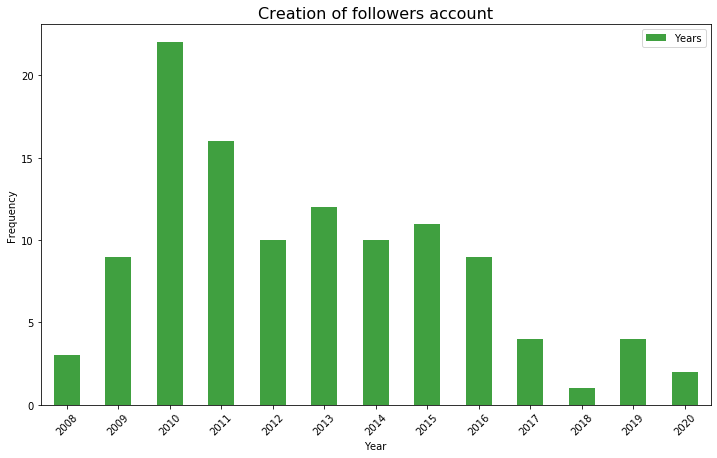

In [17]:
# Plot creation of followers account
x_var = 'year'
y_var = 'frequency'
title = 'Creation of followers account'
legend = ['Years']
figsize = (12, 7)
plot_col_chart(df, x_var, y_var, title, legend, figsize)

## 4. Tweets Basic Analytics

### 4.1. Length of Tweets

In [18]:
# Tweet length
n_tweets = len(tweet_list)
tweets_len = []

for tweet in tweet_list:
    tweets_len.append(len(tweet['message']))

In [19]:
# Showing stats
print('Number of tweets: %s' % n_tweets)
print('Minimum length: %s' % np.min(tweets_len))
print('Maximum length: %s' % np.max(tweets_len))
print('Average length: %.2f' % np.mean(tweets_len))
print('Standard deviation: %.2f' % np.std(tweets_len))

Number of tweets: 199
Minimum length: 15
Maximum length: 304
Average length: 149.08
Standard deviation: 80.36


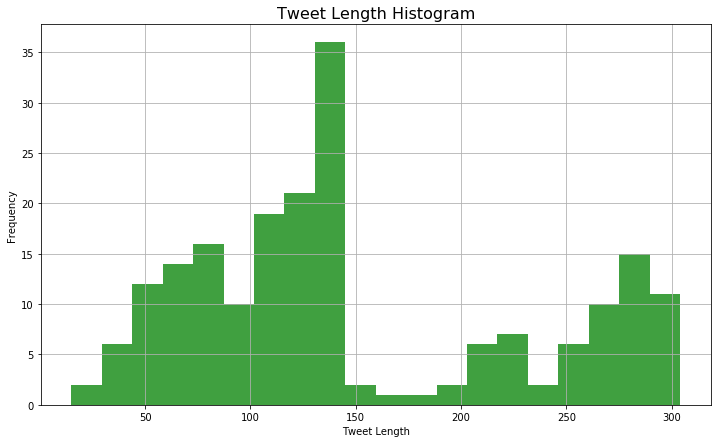

In [20]:
# Plot histograma of the tweet length
fig = plt.figure(figsize = (12, 7))
plt.hist(tweets_len, 20, facecolor='green', alpha=0.75)
plt.title('Tweet Length Histogram', fontsize=16)
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### 4.2. Stats of Retweets and Favorites

In [21]:
# Retweet and favorite stats
retweet_count = []
favorite_count = []

for tweet in tweet_list:
    if not tweet['retweeted']:
        retweet_count.append(tweet['retweet_count'])
        favorite_count.append(tweet['favorite_count'])

In [22]:
# Showing statistics of account tweets
print('Retweets total: %s' % np.sum(retweet_count))
print('Retweets average: %.2f' % np.mean(retweet_count))
print('Favorites total: %s' % np.sum(favorite_count))
print('Favorites average: %.2f' % np.mean(favorite_count))

Retweets total: 84
Retweets average: 0.53
Favorites total: 225
Favorites average: 1.41


### 4.3. Tweets Language

In [23]:
# Count the language of the tweets
lang_list = Counter()
lang_dict = {'en': 'English', 'es': 'Spanish', 'de': 'Deutsch', 'und': 'Undefined'}

for tweet in tweet_list:
    lang = lang_dict[tweet['lang']]
    lang_list[lang] += 1

print('Total tweets language: %s' % len(lang_list))

Total tweets language: 3


In [24]:
# Cooking dataframe
df = pd.DataFrame.from_records(lang_list.most_common(), columns = ['language', 'frequency'])

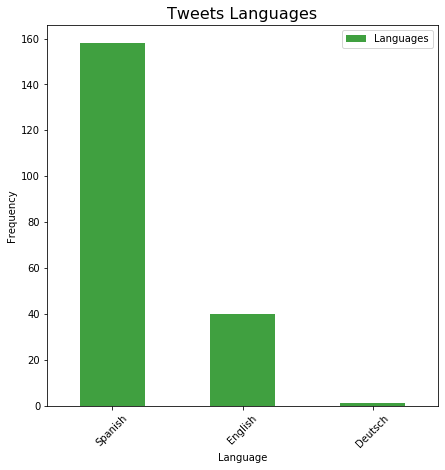

In [25]:
# Plot the language of the tweets
x_var = 'language'
y_var = 'frequency'
title = 'Tweets Languages'
legend = ['Languages']
figsize = (7, 7)
plot_col_chart(df, x_var, y_var, title, legend, figsize)

### 4.4. Tweets by Day of Week and by Year

In [26]:
# Count the language of the tweets
tweets_year = Counter()
tweets_day = Counter()

for tweet in tweet_list:
    created_at = tweet['created_at'].date()
    weekday = created_at.weekday()
    year = created_at.year
    
    tweets_day[weekday] += 1
    tweets_year[year] += 1

In [27]:
# Cooking dataframe
df = pd.DataFrame.from_records(list(tweets_day.items()), columns = ['weekday', 'frequency']).sort_values(by=['weekday'])
x = np.arange(7)
x_label = [calendar.day_name[d] for d in x]

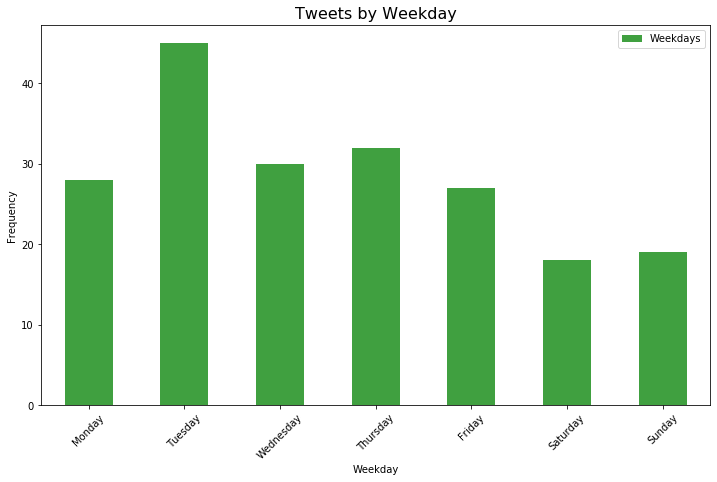

In [28]:
# Plot tweets by weekday
x_var = 'weekday'
y_var = 'frequency'
title = 'Tweets by Weekday'
legend = ['Weekdays']
figsize = (12, 7)
color = 'green'
x_label = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plot_col_chart(df, x_var, y_var, title, legend, figsize, color, x_label)

In [29]:
# Cooking dataframe
df = pd.DataFrame.from_records(tweets_year.most_common(), columns = ['year', 'frequency']).sort_values(by=['year'])

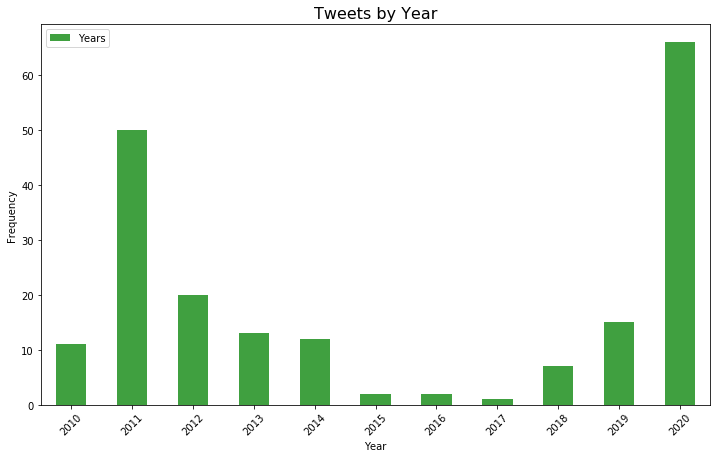

In [30]:
# Plot tweets by year
x_var = 'year'
y_var = 'frequency'
title = 'Tweets by Year'
legend = ['Years']
figsize = (12, 7)
plot_col_chart(df, x_var, y_var, title, legend, figsize)

### 4.5. Tweeting Sources

In [31]:
# Count the source of the tweets
tweets_source = Counter()

for tweet in tweet_list:
    year = tweet['source']
    tweets_source[year] += 1

print('Total tweeting sources: %s' % len(tweets_source))

Total tweeting sources: 7


In [32]:
# Cooking dataframe
df = pd.DataFrame.from_records(tweets_source.most_common(), columns = ['source', 'frequency'])

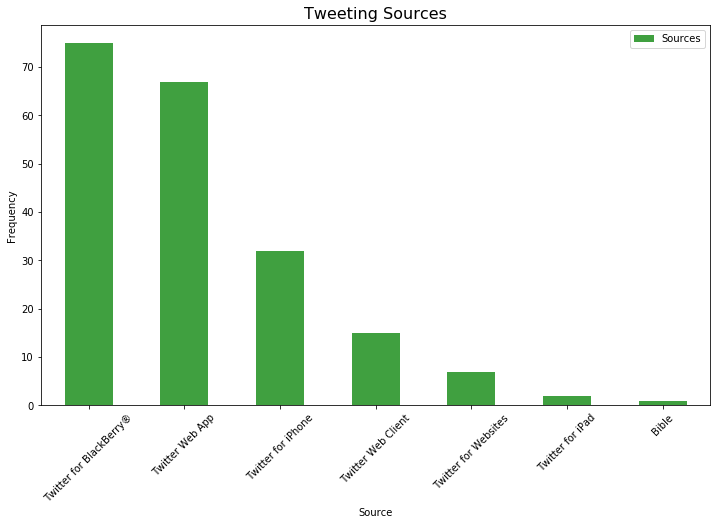

In [33]:
# Plot tweeting Sources
x_var = 'source'
y_var = 'frequency'
title = 'Tweeting Sources'
legend = ['Sources']
figsize = (12, 7)
plot_col_chart(df, x_var, y_var, title, legend, figsize)

## 5. NLP Analytics

In [34]:
# Util function - Clean tweet text
def dq_clean_text(text):
    clean_text = text.lower()
    clean_text = re.sub(rx, ' ', clean_text)
    clean_text = re.sub(r'\.+', ' ', clean_text)
    clean_text = re.sub(r'\s+', ' ', clean_text)
    return clean_text

In [35]:
# Global NLP variables
n_top = 20
punt_marks = ['\n', '\'', '\\', '/', '¡', '!', '¿', '?', '.', ',', ';', ':', '#', '$', '%', '&', '(', ')', '"']
rx = '[' + re.escape(''.join(punt_marks)) + ']'

In [36]:
# Counter of used words
word_list = Counter()

# Create list of words
for tweet in tweet_list:
    tweet_text = tweet['message']
    
    # Clean tweet text
    clean_text = dq_clean_text(tweet_text)
    
    # Save mentioned accounts
    for word in clean_text.split(' '):
        if len(word) and not word.isnumeric():
            word_list[word] += 1

print('Number of words used: %s' % len(word_list))
print('Average words per tweet: %.2f' % (len(word_list) / n_tweets))

Number of words used: 1733
Average words per tweet: 8.71


### 5.1. Most mentioned User Accounts

In [37]:
# Most mentioned accounts list
tw_accounts = Counter()

# Save mentioned accounts
for word, freq in list(word_list.items()):
    if word[0] == '@' and word != tw_user_name:
        tw_accounts[word] = freq

print('Total different mentioned accounts: %s' % len(tw_accounts))
print('Average mentioned accounts per tweet: %.2f' % (sum(tw_accounts.values())/n_tweets))

Total different mentioned accounts: 55
Average mentioned accounts per tweet: 0.44


In [38]:
# Cooking dataframe
top_accounts = tw_accounts.most_common(n_top)
df = pd.DataFrame.from_records(top_accounts, columns = ['account', 'frequency']).sort_values(by=['frequency'])

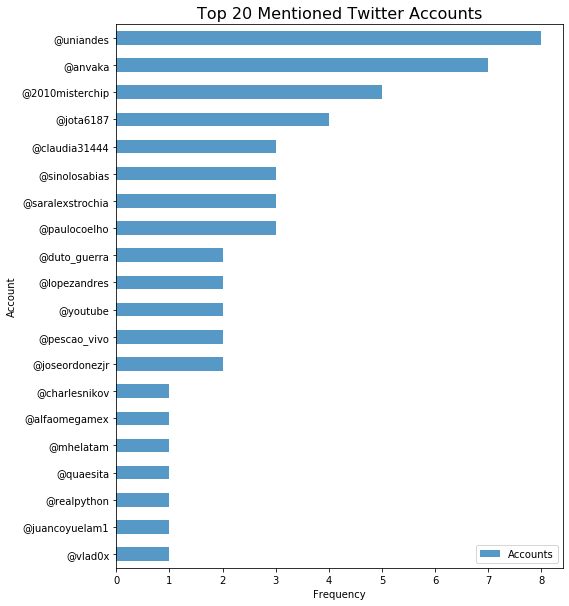

In [39]:
# Plot top N mentioned accounts
x_var = 'account'
y_var = 'frequency'
title = 'Top %s Mentioned Twitter Accounts' % n_top
legend = ['Accounts']
figsize = (8, 10)
plot_bar_chart(df, x_var, y_var, title, legend, figsize)

### 5.2. Most used Hashtags in Tweets

In [40]:
# Count the hashtags in the tweets and return the N most repeated 
hashtags = Counter()

for t in tweet_list:
    for ht in t['hashtags']:
        ht = '#'+ht.lower()
        hashtags[ht] += 1

print('Total used different hashtags: %s' % len(hashtags))
print('Average hashtags per tweet: %.2f' % (sum(hashtags.values())/n_tweets))

Total used different hashtags: 55
Average hashtags per tweet: 0.73


In [41]:
# Cooking dataframe
top_hashtags = hashtags.most_common(n_top)
df = pd.DataFrame.from_records(top_hashtags, columns = ['hashtag', 'frequency']).sort_values(by=['frequency'])

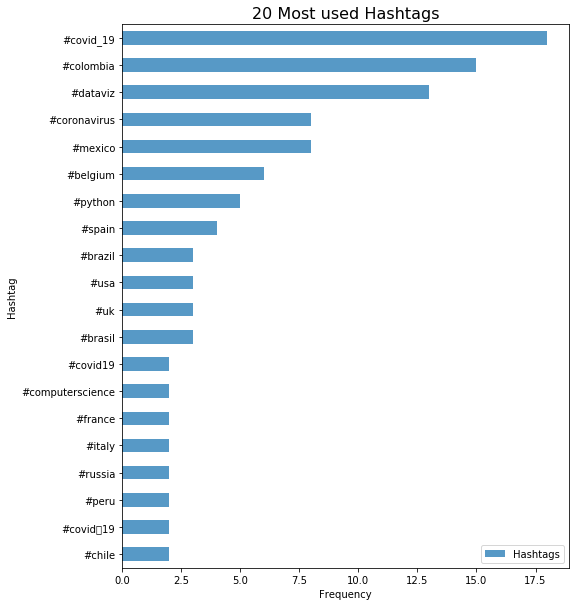

In [42]:
# Plot the most common hashtags in tweets
x_var = 'hashtag'
y_var = 'frequency'
title = '%s Most used Hashtags' % n_top
legend = ['Hashtags']
figsize = (8, 10)
plot_bar_chart(df, x_var, y_var, title, legend, figsize)

### 5.3. Most common Words in Tweets

In [43]:
# Add word-freq to Dataframe
df = pd.DataFrame(columns=['word', 'frequency'])
ix = 0

# Filter twitter accounts
for word, freq in word_list.most_common():
    if ix == n_top:
        break
    elif len(word) > 2 and word[0] != '@':
        df.loc[ix] = (word, freq)
        ix += 1

# Sorting data by frequency
df = df.sort_values(by=['frequency'])

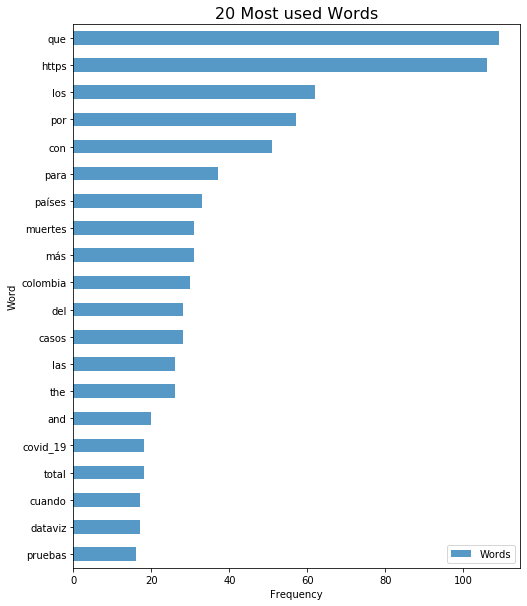

In [44]:
# Plot the most common words in tweets
x_var = 'word'
y_var = 'frequency'
title = '%s Most used Words' % n_top
legend = ['Words']
figsize = (8, 10)
plot_bar_chart(df, x_var, y_var, title, legend, figsize)

### 5.4. Most common Words w/o Stopwords

In [45]:
# Get Spanish stopwords
stopwords_es = es.stop_words.STOP_WORDS
stopwords_en = en.stop_words.STOP_WORDS | set({'http', 'https'})

In [46]:
# Add word-freq to Dataframe
df = pd.DataFrame(columns=['word', 'frequency'])
ix = 0

# Filter English and Spanihs stopwords
for word, freq in word_list.most_common():
    if ix == n_top:
        break
    elif (word not in stopwords_es) and (word not in stopwords_en) and (len(word) > 2) and (word[0] != '@'):
        df.loc[ix] = (word, freq)
        ix += 1

# Sorting data by frequency
df = df.sort_values(by=['frequency'])

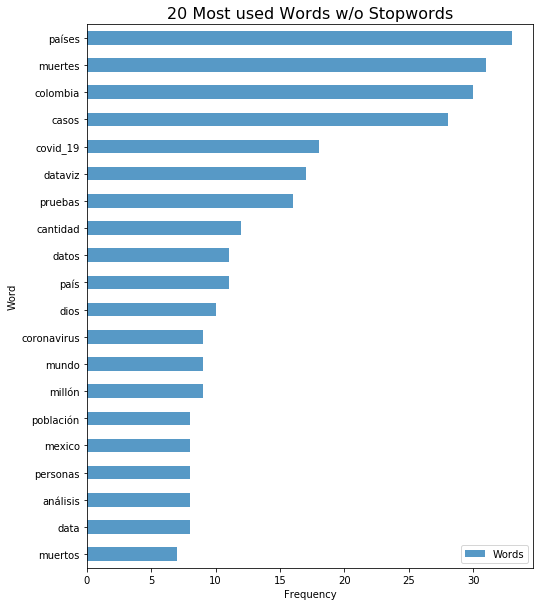

In [47]:
# Plot the most common words in tweets
x_var = 'word'
y_var = 'frequency'
title = '%s Most used Words w/o Stopwords' % n_top
legend = ['Words']
figsize = (8, 10)
plot_bar_chart(df, x_var, y_var, title, legend, figsize)

### 5.5. Tweet WordCloud

In [48]:
# Reconstructing the clean text (without stop-words)
new_clean_text = user.description

# Create list of words
for tweet in tweet_list:
    tweet_text = tweet['message']
    clean_text = dq_clean_text(tweet_text)
    for word in clean_text.split(' '):
        if (word not in stopwords_es) and (word not in stopwords_en) and (len(word) > 2) and (word[0] != '@'):
            new_clean_text += ' ' + word

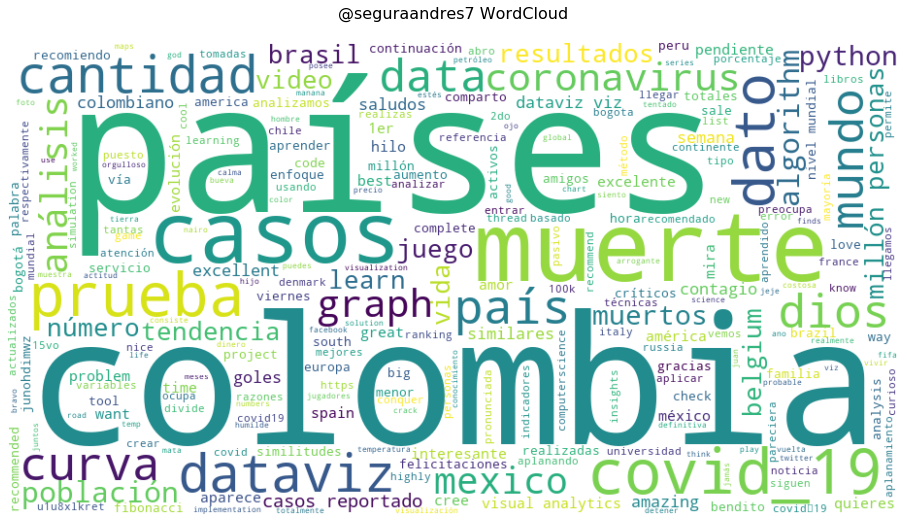

In [49]:
# Import mask
mask = np.array(Image.open('../img/twitter-mask.png'))

# Create a Word-cloud
wc = WordCloud(background_color="white", max_words=250, mask=mask, margin=2)
wc = wc.generate(new_clean_text)

# Plot a Word-cloud of words of tweets
plt.figure(figsize = (16, 10))
image = plt.imshow(wc, interpolation = "bilinear")
plt.title('%s WordCloud\n' % tw_user_name, fontsize=16)
plt.axis("off")

# Save the Word-cloud image
plt.savefig('../img/wordcloud.png')
plt.show()

## 6. Sentiment Analysis

Sentiment analysis is done with the TextBlob library. Tweets that were not written in English are previously translated.

In [50]:
# Functions to discretize the sentiment analysis results
def get_polarity(polarity):
    if polarity >= 0.25:
        return 'positive'
    elif polarity <= -0.25:
        return 'negative'
    return 'neutral'

def get_subjectivity(subjectivity):
    if subjectivity >= 0.5:
        return 'subjective'
    return 'objective'

In [51]:
# Calculate the sentiment of the tweet
allow_translation = True
lang_dest = 'en'
polarity_list = Counter({'positive': 0, 'negative': 0, 'neutral': 0})
subjectivity_list = Counter({'subjective': 0, 'objective': 0})

for tweet in tweet_list:
    message = tweet['message']
    lang_source = tweet['lang']
    
    try:
        analysis = TextBlob(message)

        # If the language of the tweet is different from English, it is translated
        if allow_translation and (lang_source != lang_dest):
            analysis = analysis.translate(to=lang_dest)
            time.sleep(0.1)
        
        # Apply sent-analysis
        polarity = get_polarity(analysis.sentiment.polarity)
        subjectivity = get_subjectivity(analysis.sentiment.subjectivity)

        # Save results
        polarity_list[polarity] += 1
        subjectivity_list[subjectivity] += 1
    except:
        pass

In [52]:
# Cooking dataframe
df = pd.DataFrame.from_records(list(polarity_list.items()), columns = ['polarity', 'frequency'])
df

,polarity,frequency
0,positive,22
1,negative,1
2,neutral,17


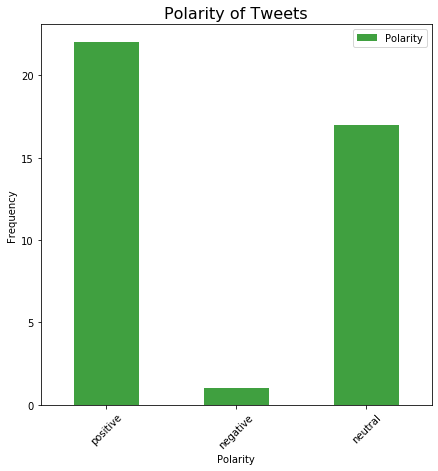

In [53]:
# Plot the polarity of tweets
x_var = 'polarity'
y_var = 'frequency'
title = 'Polarity of Tweets'
legend = ['Polarity']
figsize = (7, 7)
plot_col_chart(df, x_var, y_var, title, legend, figsize)

In [54]:
# Cooking dataframe
df = pd.DataFrame.from_records(list(subjectivity_list.items()), columns = ['subjectivity', 'frequency'])
df

,subjectivity,frequency
0,subjective,19
1,objective,21


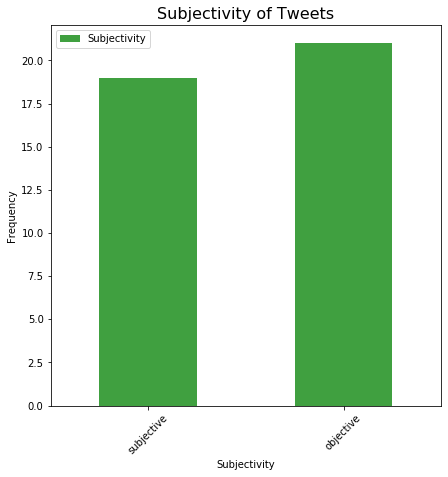

In [55]:
# Plot the subjectivity of tweets
x_var = 'subjectivity'
y_var = 'frequency'
title = 'Subjectivity of Tweets'
legend = ['Subjectivity']
figsize = (7, 7)
plot_col_chart(df, x_var, y_var, title, legend, figsize)

<hr>
<p><a href="https://github.com/ansegura7/TwitterAnalytics">« Home</a></p>